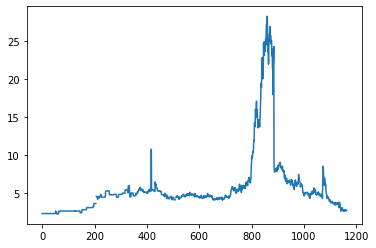

In [4]:
#%% import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split

#%% data loading
train_path = os.path.join(os.getcwd(),'dataset','Top_Glove_Stock_Price_Train(Modified).csv')
test_path = os.path.join(os.getcwd(),'dataset','Top_Glove_Stock_Price_Test.csv')

df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path, names=df.columns)

#%% EDA
plt.figure()
plt.plot(df['Open'])
plt.show()

#%% data cleaning

# Na value guna cara interpolate

df['Open'] = df['Open'].interpolate(method="polynomial", order=2)

#%% feature selection
x = np.expand_dims(df['Open'].values, axis=-1)

#%% data preprosessing

mms = MinMaxScaler()
x = mms.fit_transform(x)

x_list = []
y_list = []
win_size = 60

for i in range(win_size, len(x)):
    x_list.append(x[i-win_size:i])
    y_list.append(x[i])

x = np.array(x_list)
y = np.array(y_list)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=123)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
7/7 [==============================] - 1s 43ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 2/500
7/7 [==============================] - 0s 26ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 3/500
7/7 [==============================] - 0s 15

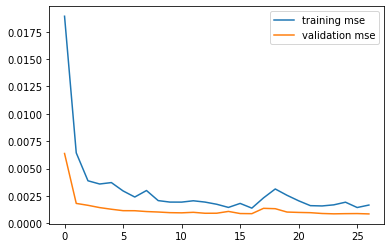

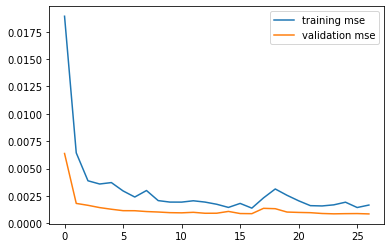

In [5]:
#%% model developmnet
from keras.layers import SimpleRNN, Dense, Dropout, LSTM
from keras import Sequential
from keras.utils import plot_model
import datetime
from keras.callbacks import TensorBoard, EarlyStopping

input_shape = np.shape(x_train)[1:]
nb_class = np.shape(y_train)[-1]

model = Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(nb_class, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics='mse')
model.summary()
plot_model(model, show_shapes=True)

log_dir = os.path.join(os.getcwd(), 'logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor='loss',patience=10)
hist = model.fit(x_train,y_train, batch_size=128,validation_data=(x_test,y_test),epochs=500, callbacks=[tb_callback,es_callback])

#%% model analysis

plt.figure()
plt.plot(hist.history['mse']) # line graph
plt.plot(hist.history['val_mse'])
plt.legend(['training mse', 'validation mse'])
plt.show()

plt.figure()
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.legend(['training mse', 'validation mse'])
plt.show()


11/11 [==============================] - 0s 4ms/step
DL MAE error is 0.011300226295500626
DL MAPE error is 0.08757929414616118
DL R2 value is 0.9726222910958561
3/3 [==============================] - 0s 4ms/step


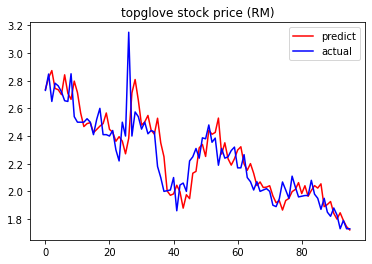

DL MAE error is 0.0984411088903745
DL MAPE error is 0.043170914210983256
DL R2 value is 0.757151876361013


In [7]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score

y_pred = model.predict(x_test)

print('DL MAE error is {}'.format(mean_absolute_error(y_test,y_pred))) # lg kecik lagi bagus
print('DL MAPE error is {}'.format(mean_absolute_percentage_error(y_test,y_pred))) # percentage lg kecik lgi bagus
print('DL R2 value is {}'.format(r2_score(y_test,y_pred))) # kene dekat dengan 1

#%% with the real test dataset

df_t = pd.concat((df,df_test))
df_t = df_t['Open'].values
df_t = mms.transform(np.expand_dims(df_t,axis=-1))

x_actual = []
y_actual = []

for i in range(len(df), len(df_t)):
    x_actual.append(df_t[i-win_size:i])
    y_actual.append(df_t[i])

x_actual = np.array(x_actual)
y_actual = np.array(y_actual)

y_pred_ac = model.predict(x_actual)
y_pred_ac = mms.inverse_transform(y_pred_ac)
y_actual = mms.inverse_transform(y_actual)

plt.figure()
plt.plot(y_pred_ac, color='red')
plt.plot(y_actual, color='blue')
plt.legend(["predict", "actual"])
plt.title("topglove stock price (RM)")
plt.show()

print('DL MAE error is {}'.format(mean_absolute_error(y_actual,y_pred_ac))) # lg kecik lagi bagus
print('DL MAPE error is {}'.format(mean_absolute_percentage_error(y_actual,y_pred_ac))) # percentage lg kecik lgi bagus
print('DL R2 value is {}'.format(r2_score(y_actual,y_pred_ac))) # kene dekat dengan 1